In [1]:
import keras

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5836748157948527865
]


In [3]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, merge, Dropout, add,concatenate


from keras.models import Model

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [32]:
os.chdir("C:\\Users\\rohan\\Desktop\\LeadingIndia.ai\\TASK2")
data_train=pd.read_csv('election.csv')
data_train.head(10)
data_train['label']=data_train.is_fake_news

In [33]:
def clean_str(string):
    """
    Cleaning of dataset
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()


In [34]:
#data_train = pd.read_csv('train_Mixed.csv')
data_train.text[1]

"@realDonaldTrump you're fucking retarded"

In [35]:
# Input Data preprocessing
#data_train = pd.read_csv('data/train_Mixed.csv')
#data_train['label'] = data_train['label'].replace('FAKE',1)
#data_train['label'] = data_train['label'].replace('REAL',0)
print(data_train.columns)
print('What the raw input data looks like:')
print(data_train[0:5])
texts = []
labels = []

for i in range(data_train.text.shape[0]):
    text1 = data_train.tweet_id[i]
    text2 = data_train.text[i]
    text = str(text1) +""+ str(text2)
    texts.append(text)
    labels.append(data_train.label[i])
    
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Index(['is_fake_news', 'fake_news_category', 'tweet_id', 'created_at',
       'retweet_count', 'text', 'user_screen_name', 'user_verified',
       'user_friends_count', 'user_followers_count', 'user_favourites_count',
       'tweet_source', 'geo_coordinates', 'num_hashtags', 'num_mentions',
       'num_urls', 'num_media', 'label'],
      dtype='object')
What the raw input data looks like:
   is_fake_news  fake_news_category            tweet_id  \
0         False                 NaN  264033382076407808   
1         False                 NaN  265895586660757505   
2         False                 NaN  265895723445411841   
3         False                 NaN  265896172726661120   
4         False                 NaN  266042962650226688   

                       created_at  retweet_count  \
0  Thu Nov 01 15:57:18 +0000 2012           4698   
1  Tue Nov 06 19:17:02 +0000 2012           9646   
2  Tue Nov 06 19:17:35 +0000 2012           1823   
3  Tue Nov 06 19:19:22 +0000 2012           1

In [36]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (1327, 1000)
Shape of label tensor: (1327, 2)


In [37]:
# Train test validation Split
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( data, labels, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake news in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 1061 664 663
real & fake news in train,valt,test:
[955. 106.]
[597.  67.]
[594.  69.]


In [39]:
#Using Pre-trained word embeddings
os.chdir("C:\\Users\\rohan\\Desktop\\LeadingIndia.ai")
GLOVE_DIR = "data" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

Total 400000 word vectors in Glove.


In [40]:
# Simple CNN model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

print("Fitting the simple convolutional neural network model")
model.summary()
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=3, batch_size=128)

Fitting the simple convolutional neural network model
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         672600    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
conv1

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1061 samples, validate on 664 samples
Epoch 1/3
1061/1061 [==============================] - 4s 4ms/step - loss: 0.4076 - acc: 0.7983 - val_loss: 0.3948 - val_acc: 0.8991
Epoch 2/3
1061/1061 [==============================] - 4s 4ms/step - loss: 0.3436 - acc: 0.9001 - val_loss: 0.3546 - val_acc: 0.8991
Epoch 3/3
1061/1061 [==============================] - 4s 4ms/step - loss: 0.3249 - acc: 0.9001 - val_loss: 0.3244 - val_acc: 0.8991


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


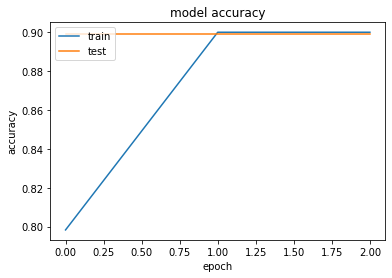

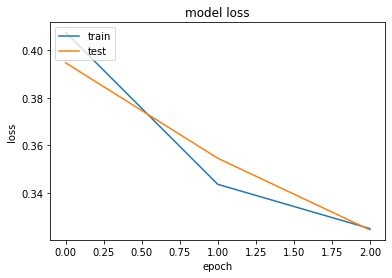

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
#convolutional approach
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)
    
#l_merge = merge(mode='concat', concat_axis=1)(convFs)
#l_merge= Modell.merge(mode='concat', concat_axis=1)
#l_merge = merge(mode='concat', concat_axis=1)(convFs)
#l_merge = merge(mod="cos", dot_axes=1)
l_merge = concatenate(convs, axis=1)
l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(filters=128, kernel_size=5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model2 = Model(sequence_input, preds)
model2.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['acc'])

print("Fitting a more complex convolutional neural network model")
model2.summary()
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=3, batch_size=50)
model2.save('model.h5')

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`
  if __name__ == '__main__':


Fitting a more complex convolutional neural network model
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    672600      input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 998, 128)     38528       embedding_1[1][0]                
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 997, 128)     51328       embedding_1[1][0]                
__________________________________

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1061 samples, validate on 664 samples
Epoch 1/3
1061/1061 [==============================] - 11s 10ms/step - loss: 0.3711 - acc: 0.9001 - val_loss: 0.3713 - val_acc: 0.8991
Epoch 2/3
1061/1061 [==============================] - 11s 10ms/step - loss: 0.3328 - acc: 0.9001 - val_loss: 0.4137 - val_acc: 0.8991
Epoch 3/3
1061/1061 [==============================] - 11s 10ms/step - loss: 0.3252 - acc: 0.9001 - val_loss: 0.4087 - val_acc: 0.8991


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


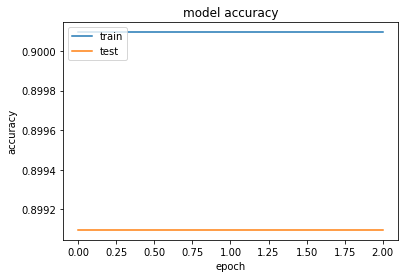

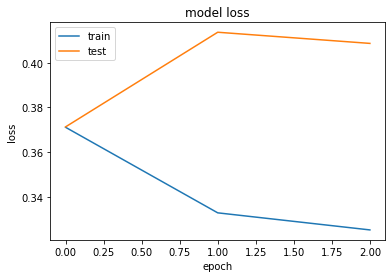

In [47]:
# list all data in history
print(history2.history.keys())
import matplotlib.pyplot as plt
%matplotlib inline 
# summarize history for accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Correct predictions: 594.0
Total number of test examples: 663
Accuracy of model1:  0.8959276018099548
Correct predictions: 594.0
Total number of test examples: 663
Accuracy of model2:  0.8959276018099548


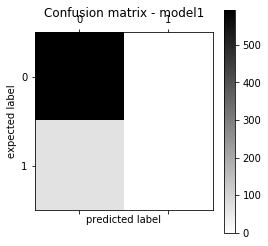

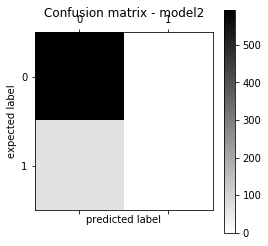

In [48]:
# Test model 1
test_preds = model.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = model.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
plt.title('Confusion matrix - model1')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
# plt.show()

#Test model 2
test_preds2 = model2.predict(x_test)
test_preds2 = np.round(test_preds2)
correct_predictions = float(sum(test_preds2 == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model2: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
x_pred = model2.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest',)
plt.title('Confusion matrix - model2')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

In [49]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.32783460435015044
Test accuracy: 0.8959276080131531


In [50]:
score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4049040026299734
Test accuracy: 0.8959276080131531
